<a href="https://colab.research.google.com/github/Navya-S/ERA_Session10/blob/main/session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [26]:
import numpy as np
import torch
import torch.nn as nn

In [27]:
import torch
import torch.nn as nn


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()

        self.resblock = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(0.1)

        )

    def forward(self, x):
        return x + self.resblock(x)


class CustomResnet(nn.Module):
    def __init__(self):
        super(CustomResnet, self).__init__()

        self.prep = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResBlock(channels=128),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ResBlock(channels=512),
        )

        self.pool = nn.MaxPool2d(kernel_size=4)

        self.fc = nn.Linear(in_features=512, out_features=10, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install torchinfo
!pip install torch_lr_finder
import torch
import torchvision
from torchinfo import summary
from torch_lr_finder import LRFinder


def find_lr(model, optimizer, criterion, device, trainloader, numiter, startlr, endlr):
    lr_finder = LRFinder(
        model=model, optimizer=optimizer, criterion=criterion, device=device
    )

    lr_finder.range_test(
        train_loader=trainloader,
        start_lr=startlr,
        end_lr=endlr,
        num_iter=numiter,
        step_mode="exp",
    )

    lr_finder.plot()

    lr_finder.reset()


def one_cycle_lr(optimizer, maxlr, steps, epochs):
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=maxlr,
        steps_per_epoch=steps,
        epochs=epochs,
        pct_start=5 / epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy="linear",
    )
    return scheduler


def show_random_images_for_each_class(train_data, num_images_per_class=16):
    for c, cls in enumerate(train_data.classes):
        rand_targets = random.sample(
            [n for n, x in enumerate(train_data.targets) if x == c],
            k=num_images_per_class,
        )
        show_img_grid(np.transpose(train_data.data[rand_targets], axes=(0, 3, 1, 2)))
        plt.title(cls)


def show_img_grid(data):
    try:
        grid_img = torchvision.utils.make_grid(data.cpu().detach())
    except:
        data = torch.from_numpy(data)
        grid_img = torchvision.utils.make_grid(data)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))


def show_random_images(data_loader):
    data, target = next(iter(data_loader))
    show_img_grid(data)


def show_model_summary(model, batch_size):
    summary(
        model=model,
        input_size=(batch_size, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        verbose=1,
    )

In [29]:
import torchvision
# from utils.transforms import train_transform, test_transform

from tqdm import tqdm
import torch
import torch.nn.functional as F


def train(
    model,
    device,
    train_loader,
    optimizer,
    criterion,
    L1=False,
    l1_lambda=0.01,
):
    model.train()
    pbar = tqdm(train_loader)

    train_losses = []
    train_acc = []

    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        if L1:
            l1_loss = 0
            for p in model.parameters():
                l1_loss = l1_loss + p.abs().sum()
            loss = loss + l1_lambda * l1_loss
        else:
            loss = loss

        train_loss += loss.item()
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)

    return train_losses, train_acc

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010),
            always_apply=True,
        ),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(
            min_holes=1,
            max_holes=1,
            min_height=8,
            min_width=8,
            max_height=8,
            max_width=8,
            fill_value=(0.4914, 0.4822, 0.4465),  # type: ignore
            p=0.5,
        ),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010),
            always_apply=True,
        ),
        ToTensorV2(),
    ]
)

def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    test_acc = 100.0 * correct / len(test_loader.dataset)

    return test_loss, test_acc



class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


train_dataset = Cifar10SearchDataset(
    root="./data", train=True, transform=train_transform
)

test_dataset = Cifar10SearchDataset(
    root="./data", train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# from models.custom_resnet import CustomResnet
# from utils.data import train_dataset, test_dataset
# from utils.training import train, test

# from utils.common import (
#     find_lr,
#     one_cycle_lr,
#     show_model_summary,
#     show_img_grid,
#     show_random_images,
#     show_random_images_for_each_class,
# )

### Create Dataloaders

In [31]:
batch_size = 512
shuffle = True
num_workers = 4

In [32]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Check Sample Images

In [33]:
images, labels = next(iter(trainloader))

In [34]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(3))

In [35]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


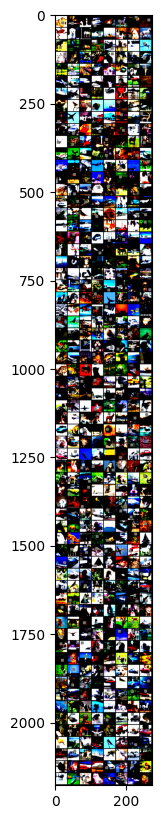

In [36]:
show_random_images(data_loader=trainloader)

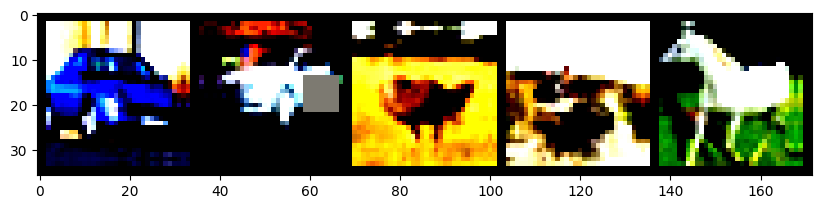

In [37]:
show_img_grid(images[25:30])

### Set Device

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
device

'cuda'

### Generate Model Summary

In [40]:
model = CustomResnet().to(device)

In [41]:
show_model_summary(model, batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CustomResnet                             [512, 3, 32, 32]          [512, 10]                 --                        --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --
│    └─Conv2d: 2-1                       [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    └─ReLU: 2-3                         [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
├─Sequential: 1-2                        [512, 64, 32, 32]         [512, 128, 16, 16]        --                        --
│    └─Conv2d: 2-4                       [512, 64, 32, 32]         [512, 128, 32, 32]        73,728                    [3, 3]
│    └

### Declare Optimizer & Criterion

In [42]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.00E-02


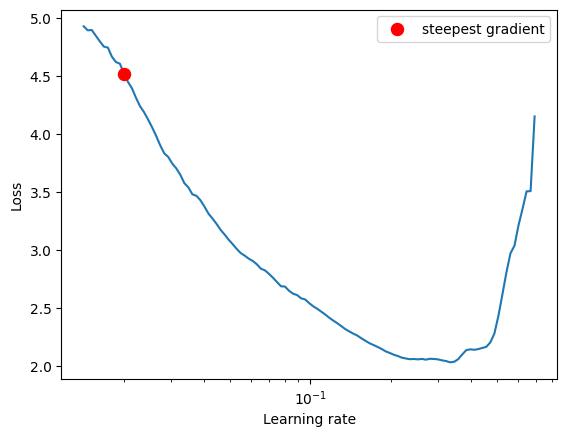

In [43]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=200,
    endlr=10,
    startlr=1e-2,
)

### Create the Scheduler - One Cycle Policy

In [46]:
epochs = 24
maxlr = 2.0E-02
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [47]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    scheduler.step()

Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.0008759498596191 Batch_id=97 Accuracy=60.40: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.9514, Accuracy: 6633/10000 (66.33%)

Epoch: 2


Loss=0.8184991478919983 Batch_id=97 Accuracy=69.25: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.8105, Accuracy: 7186/10000 (71.86%)

Epoch: 3


Loss=0.8290898203849792 Batch_id=97 Accuracy=74.38: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.6492, Accuracy: 7743/10000 (77.43%)

Epoch: 4


Loss=0.5959908366203308 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.5737, Accuracy: 7996/10000 (79.96%)

Epoch: 5


Loss=0.5820773243904114 Batch_id=97 Accuracy=80.78: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.5564, Accuracy: 8054/10000 (80.54%)

Epoch: 6


Loss=0.5439820289611816 Batch_id=97 Accuracy=82.61: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.5527, Accuracy: 8092/10000 (80.92%)

Epoch: 7


Loss=0.496214359998703 Batch_id=97 Accuracy=84.09: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.4957, Accuracy: 8299/10000 (82.99%)

Epoch: 8


Loss=0.40745794773101807 Batch_id=97 Accuracy=85.40: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.4760, Accuracy: 8415/10000 (84.15%)

Epoch: 9


Loss=0.3368024528026581 Batch_id=97 Accuracy=86.84: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.5033, Accuracy: 8354/10000 (83.54%)

Epoch: 10


Loss=0.3095720708370209 Batch_id=97 Accuracy=87.65: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.4245, Accuracy: 8535/10000 (85.35%)

Epoch: 11


Loss=0.31847357749938965 Batch_id=97 Accuracy=88.53: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.4043, Accuracy: 8606/10000 (86.06%)

Epoch: 12


Loss=0.33962398767471313 Batch_id=97 Accuracy=89.07: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4131, Accuracy: 8641/10000 (86.41%)

Epoch: 13


Loss=0.2630654275417328 Batch_id=97 Accuracy=89.46: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.3851, Accuracy: 8662/10000 (86.62%)

Epoch: 14


Loss=0.33898547291755676 Batch_id=97 Accuracy=90.20: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.3563, Accuracy: 8795/10000 (87.95%)

Epoch: 15


Loss=0.2623632848262787 Batch_id=97 Accuracy=90.54: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.4004, Accuracy: 8678/10000 (86.78%)

Epoch: 16


Loss=0.23085792362689972 Batch_id=97 Accuracy=91.22: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.3851, Accuracy: 8720/10000 (87.20%)

Epoch: 17


Loss=0.2034233808517456 Batch_id=97 Accuracy=91.06: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.3566, Accuracy: 8812/10000 (88.12%)

Epoch: 18


Loss=0.26066842675209045 Batch_id=97 Accuracy=91.85: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.3968, Accuracy: 8707/10000 (87.07%)

Epoch: 19


Loss=0.18137289583683014 Batch_id=97 Accuracy=92.18: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.3164, Accuracy: 8935/10000 (89.35%)

Epoch: 20


Loss=0.22322042286396027 Batch_id=97 Accuracy=92.53: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4080, Accuracy: 8700/10000 (87.00%)

Epoch: 21


Loss=0.20786678791046143 Batch_id=97 Accuracy=92.60: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.3835, Accuracy: 8796/10000 (87.96%)

Epoch: 22


Loss=0.22054129838943481 Batch_id=97 Accuracy=93.01: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.3672, Accuracy: 8810/10000 (88.10%)

Epoch: 23


Loss=0.2236238718032837 Batch_id=97 Accuracy=92.85: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.3222, Accuracy: 8932/10000 (89.32%)

Epoch: 24


Loss=0.15581505000591278 Batch_id=97 Accuracy=92.95: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.3428, Accuracy: 8890/10000 (88.90%)



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(range(epochs), results["trainloss"])
plt.plot(range(epochs), results["testloss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
plt.plot(range(epochs), results["trainacc"])
plt.plot(range(epochs), results["testacc"])
plt.legend(["Train Acc", "Validation Acc"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()